In [3]:
pip install fpdf

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40715 sha256=c7cf195baafdf060d5d65beb64fdf64d544cdead3dcd6db7b50943e6618e3b7c
  Stored in directory: c:\users\vivek\appdata\local\pip\cache\wheels\6e\62\11\dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


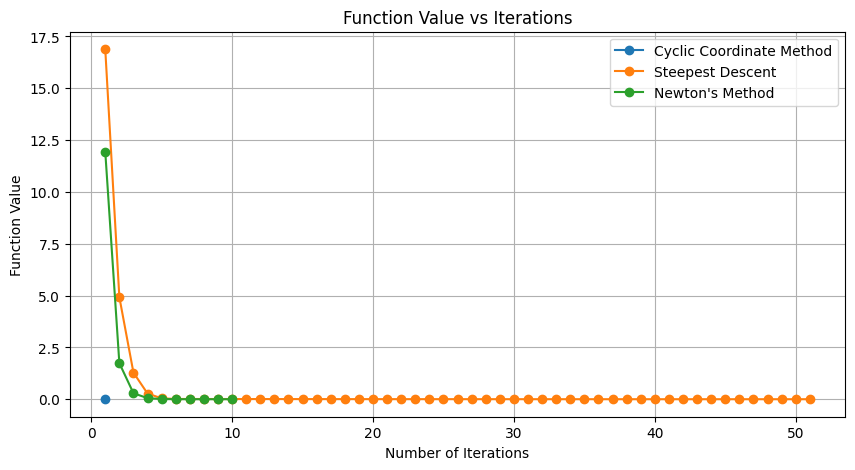

Results saved to optimization_results.pdf


In [4]:
import numpy as np
import matplotlib.pyplot as plt


from fpdf import FPDF

# Objective function
def f(x1, x2):
    return (x1**3 - x2)**2 + 2 * (x2 - x1)**4

# Gradient function
def grad_f(x1, x2):
    df_dx1 = 6 * (x1**3 - x2) * x1**2 - 8 * (x2 - x1)**3
    df_dx2 = -2 * (x1**3 - x2) + 8 * (x2 - x1)**3
    return np.array([df_dx1, df_dx2])

# Hessian matrix function
def hessian_f(x1, x2):
    d2f_dx1dx1 = 18 * x1**4 - 12 * x1**2 * x2 + 24 * (x2 - x1)**2
    d2f_dx2dx2 = 2 + 24 * (x2 - x1)**2
    d2f_dx1dx2 = -6 * x1**2 - 24 * (x2 - x1)**2
    return np.array([[d2f_dx1dx1, d2f_dx1dx2], [d2f_dx1dx2, d2f_dx2dx2]])

# Optimization function
def optimize(method, x0, tol=1e-3, max_iter=1000):
    x = np.array(x0, dtype=float)
    iterations_data = []
    iterations = 0
    method_names = {
        "CCM": "Cyclic Coordinate Method",
        "SD": "Steepest Descent",
        "NM": "Newton's Method"
    }
    method_full = method_names[method]

    for _ in range(max_iter):
        iterations += 1

        if method == "CCM":
            for i in range(2):
                e_i = np.zeros(2)
                e_i[i] = 1
                alpha = 1.0  # Start with a large step size

                # Backtracking line search
                while f(*(x + alpha * e_i)) < f(*x):
                    x += alpha * e_i
                    alpha *= 0.5  # Reduce step size
                
                while f(*(x - alpha * e_i)) < f(*x):
                    x -= alpha * e_i
                    alpha *= 0.5

        elif method == "SD":
            grad = grad_f(*x)
            alpha = 1.0  # Initial step size

            # Backtracking line search for SD
            while f(*(x - alpha * grad)) > f(*x) - 0.5 * alpha * np.linalg.norm(grad)**2:
                alpha *= 0.5
            
            x_new = x - alpha * grad
            if np.linalg.norm(x_new - x) < tol:
                break
            x = x_new

        elif method == "NM":
            grad = grad_f(*x)
            hessian = hessian_f(*x)
            
            try:
                delta_x = np.linalg.solve(hessian, -grad)  # Solve Newton step
            except np.linalg.LinAlgError:
                print("Hessian is singular; stopping Newton’s method early.")
                break

            x_new = x + delta_x
            if np.linalg.norm(x_new - x) < tol:
                break
            x = x_new

        iterations_data.append([method_full, iterations, f(*x)])

        if np.linalg.norm(grad_f(*x)) < tol:
            break

    return x, iterations, f(*x), iterations_data

# Initial point
x0 = [2, 0]

# Run optimization methods
x_ccm, iter_ccm, f_ccm, data_ccm = optimize("CCM", x0)
x_sd, iter_sd, f_sd, data_sd = optimize("SD", x0)
x_nm, iter_nm, f_nm, data_nm = optimize("NM", x0)

# Save results to PDF
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font("Arial", style='B', size=12)
pdf.cell(200, 10, "Optimization Results", ln=True, align='C')
pdf.ln(10)

# First Table: Iteration-wise results
pdf.set_font("Arial", size=10)
pdf.cell(60, 10, "Method Type", 1, 0, 'C')
pdf.cell(60, 10, "Iteration", 1, 0, 'C')
pdf.cell(60, 10, "Function Value", 1, 1, 'C')

pdf.set_font("Arial", size=9)
for row in data_ccm + data_sd + data_nm:
    pdf.cell(60, 10, row[0], 1, 0, 'C')
    pdf.cell(60, 10, str(row[1]), 1, 0, 'C')
    pdf.cell(60, 10, f"{row[2]:.6f}", 1, 1, 'C')
pdf.ln(10)

# Second Table: Final results summary
pdf.set_font("Arial", style='B', size=12)
pdf.cell(200, 10, "Final Optimization Summary", ln=True, align='C')
pdf.ln(10)

pdf.set_font("Arial", size=10)
pdf.cell(60, 10, "Method Type", 1, 0, 'C')
pdf.cell(60, 10, "Final Coordinates", 1, 0, 'C')
pdf.cell(40, 10, "Function Value", 1, 0, 'C')
pdf.cell(40, 10, "Iterations", 1, 1, 'C')

pdf.set_font("Arial", size=9)
pdf.cell(60, 10, "Cyclic Coordinate Method", 1, 0, 'C')
pdf.cell(60, 10, f"({x_ccm[0]:.6f}, {x_ccm[1]:.6f})", 1, 0, 'C')
pdf.cell(40, 10, f"{f_ccm:.6f}", 1, 0, 'C')
pdf.cell(40, 10, str(iter_ccm), 1, 1, 'C')

pdf.cell(60, 10, "Steepest Descent", 1, 0, 'C')
pdf.cell(60, 10, f"({x_sd[0]:.6f}, {x_sd[1]:.6f})", 1, 0, 'C')
pdf.cell(40, 10, f"{f_sd:.6f}", 1, 0, 'C')
pdf.cell(40, 10, str(iter_sd), 1, 1, 'C')

pdf.cell(60, 10, "Newton's Method", 1, 0, 'C')
pdf.cell(60, 10, f"({x_nm[0]:.6f}, {x_nm[1]:.6f})", 1, 0, 'C')
pdf.cell(40, 10, f"{f_nm:.6f}", 1, 0, 'C')
pdf.cell(40, 10, str(iter_nm), 1, 1, 'C')

pdf.output("optimization_results.pdf")

# Plot function values over iterations
plt.figure(figsize=(10, 5))
method_names = {"CCM": "Cyclic Coordinate Method", "SD": "Steepest Descent", "NM": "Newton's Method"}
for method, data in zip(["CCM", "SD", "NM"], [data_ccm, data_sd, data_nm]):
    iterations = [row[1] for row in data]
    values = [row[2] for row in data]
    plt.plot(iterations, values, marker='o', label=method_names[method])

plt.xlabel("Number of Iterations")
plt.ylabel("Function Value")
plt.title("Function Value vs Iterations")
plt.legend()
plt.grid()
plt.show()

print("Results saved to optimization_results.pdf")
